In [3]:
%pip install datasets

In [1]:
import plotly.graph_objects as go
from datasets import load_dataset
import pandas as pd
import os
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import random
from datasets import load_dataset
from jupyterquiz import display_quiz

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg

import nltk
nltk.download('punkt')

import json
with open("./quiz.json", "r") as file:
    questions=json.load(file)


%config InlineBackend.figure_format = 'svg'

class GridWorld:
    def __init__(self, n_rows, n_cols, bonus_states):
        """
            :param bonus_states: sequence of triples (begin, end, reward)
        """
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.bonus_states = bonus_states
        self.rewards = np.zeros(n_rows*n_cols)
        self.probs = np.zeros((n_rows*n_cols, n_rows*n_cols))
        self.values = np.zeros(n_rows*n_cols)
        self.set_rewards()
        self.set_probs()
    
    def set_rewards(self):
        for i in range(self.n_cols):
            self.rewards[i] -= 0.25
            self.rewards[self.n_rows*self.n_cols - 1 - i] -= 0.25
        
        for i in range(self.n_rows):
            self.rewards[i*self.n_cols] -= 0.25
            self.rewards[i*self.n_cols + self.n_cols-1] -= 0.25
        
        for begin, end, reward in self.bonus_states:
            self.rewards[begin] = reward
            
    def set_probs(self):
        for i in range(self.n_rows*self.n_cols):
            up = i - self.n_cols
            right = i + 1
            down = i + self.n_cols
            left = i - 1
    
            # near the boundaries something changes
            if i % self.n_cols == 0:
                left = i
            if i % self.n_cols == self.n_cols - 1:
                right = i
            if i // self.n_cols == 0:
                up = i
            if i // self.n_cols == self.n_rows - 1:
                down = i
    
            self.probs[i, up] += 0.25
            self.probs[i, right] += 0.25
            self.probs[i, down] += 0.25
            self.probs[i, left] += 0.25
        
        for begin, end, _ in self.bonus_states:
            self.probs[begin, :] = 0
            self.probs[begin, end] = 1
            
    def __repr__(self):
        return str(self.rewards.reshape((self.n_rows, -1)))
    
    def bellman_solution(self, gamma=0.9):
        v = np.linalg.inv(np.eye(self.n_rows*self.n_cols) - gamma * self.probs).dot(self.rewards)
        return v.reshape(self.n_cols, -1)
    
    def update_state_values(self, gamma=0.9):
        new_values = np.zeros_like(self.values)
        for i in range(self.n_rows*self.n_cols):
            up = i - self.n_cols
            right = i + 1
            down = i + self.n_cols
            left = i - 1
            up_reward, left_reward, down_reward, right_reward = 0, 0, 0, 0
            # near the boundaries something changes
            if i % self.n_cols == 0:
                left = i
                left_reward = -1
            if i % self.n_cols == self.n_cols - 1:
                right = i
                right_reward = -1
            if i // self.n_cols == 0:
                up = i
                up_reward = -1
            if i // self.n_cols == self.n_rows - 1:
                down = i
                down_reward= -1
            up_value = up_reward + gamma*self.values[up]
            down_value = down_reward + gamma*self.values[down]
            left_value = left_reward + gamma*self.values[left]
            right_value = right_reward + gamma*self.values[right]
            new_values[i] = max(up_value, down_value, left_value, right_value)
            
        for begin, end, reward in self.bonus_states:
            new_values[begin] = reward + gamma*self.values[end]
        diff = np.linalg.norm(new_values - self.values)
        self.values = new_values
        return diff

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaysar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Markov decision process (MDP)

## Introduction

A **Markov Decision Process** (MDP) is a mathematical framework used for modeling decision-making in scenarios where outcomes are partially random and partially under the control of a decision-maker. It consists of a set of states, actions, and rewards, with state transitions governed by probabilities.

MDPs are particularly valuable in situations where decisions need to be made sequentially over time, and they are widely used in various fields such as robotics, economics, and artificial intelligence for optimizing behavior and decision-making strategies under uncertainty.

#### Example

##### Discounted Rewards
An assistant professor gets paid, say, 20K per year.

How much, in total, will the A.P. earn in their life?

20 + 20 + 20 + 20 + 20 + ... = Infinity

_What is wrong with this argument?_

---

**"A reward (payment) in the future is not worth quite as much as a reward now."**
- Because of chance of obliteration
- Because of inflation

Example:
> Being promised 10,000\$ next year is worth only 90% as
> much as receiving 10,000\$ right now.


Assuming payment $n$ years in future is worth only
$(0.9)n$ of payment now, what is the AP's **Future
Discounted Sum of Rewards**?

##### Discount factors

People in economics and probabilistic decisionmaking do this all the time.

The "Discounted sum of future rewards" using
discount factor $\gamma$ is


(reward now) +
$\gamma$ (reward in 1 time step) +
$\gamma^2$ (reward in 2 time steps) +
$\gamma^3$ 3 (reward in 3 time steps) +
(infinite sum)


Discounted sum of future rewards:
> $$
> r + \sum\limits_{k=1}^\infin\gamma^k
> $$

where $r$ is reward now

In [2]:
display_quiz(questions[0])

<IPython.core.display.Javascript object>

##### The Academic Life


![The academic life](./academiclife.jpg "life state automat")

Assume discount factor $\gamma = 0.9$

Define:

1. $J_A$ = Expected discounted future rewards starting in state A
2. $J_B$ = Expected discounted future rewards starting in state B
3. $J_T$ = Expected discounted future rewards starting in state T
4. $J_S$ = Expected discounted future rewards starting in state S
5. $J_D$ = Expected discounted future rewards starting in state D


##### Computing the Future Rewards of an Academic

A Markov system of rewards:

- Has a set of states $\set{S_1, S_2 \dots S_n}$
- Has a transition probability matrix
$P = \begin{pmatrix}
        P_{11} & P_{12} & \dots & P_{1n}        \\
        P_{21}                                  \\
        \dots                                   \\
        P_{n1} & \dots & \dots & P_{nn}         \\
    \end{pmatrix}$ where
$P_{ij} = \text{Prob}( S_i | S_j)$
- Each state has a reward $\set{r_1, r_2 \dots r_n}$
- There is a discount factor $\gamma$ where $\gamma \vert 0<\gamma<1$


On each time step:
1. Assume your state is $S_i$
2. You get given reward $r_i$
3. You randomly move to another state
4. All future rewards are discounted by $\gamma$

#### Solving a Markov System

Write $J(S_i)$ as expected discounted sum of future rewards starting in state $S_i$

$$
J(S_i) = r_i + \gamma x = r_i + \gamma(P_{i1}J(S_1)+P_{i2}J(S_2)+ \dots P_{in}J(S_n)) \\
$$


where $x$ is expected future rewards starting from your next state


$$
J = \begin{pmatrix}
        J(S_1) \\
        J(S_2) \\
        \dots   \\
        J(S_n) \\
    \end{pmatrix}
,\space
\mathcal R = \begin{pmatrix}
        r_1     \\
        r_2     \\
        \dots   \\
        r_n     \\
    \end{pmatrix}
,\space
P = \begin{pmatrix}
        P_{11} & P_{12} & \dots & P_{1n}        \\
        P_{21}                                  \\
        \dots                                   \\
        P_{n1} & \dots & \dots & P_{nn}         \\
    \end{pmatrix}
$$



##### Value Iteration: another way to solve a Markov System
Define
- $J^1(S_i)$ is expected discounted sum of rewards over the next 1 time step
- $J^2(S_i)$ is expected discounted sum rewards during next 2 steps
- $J^3(S_i)$ is expected discounted sum rewards during next 3 steps
- $J^k(S_i)$ is expected discounted sum rewards during next $k$ steps

So:
- $J^1(S_i) = r_i$
- $J^2(S_i) = r_i + \gamma \sum\limits_{j=1}^{n}p_{ij}J^1(S_J)$ where $n$ is number of states

> $$
> J^{k+1}(S_i) = r_i + \gamma \sum\limits_{j=1}^{n}p_{ij}J^k(S_J)
> $$

In [3]:
display_quiz(questions[1])

<IPython.core.display.Javascript object>

#### Let's do a value iteration

![Value Iteration](./valueit.jpg "Value Iteration")


````{admonition} Question
:class: important

Let's fill this table

| k | $J^k(\text{SUN})$ | $J^k(\text{WIND})$ | $J^k(\text{HAIL})$ | 
| ----------- | ----------- | ----------- | ----------- |
| 1 | 4 | 0 | -8 |
| 2 |  |  |  |
| 3 |  |  |  |
| 4 |  |  |  |
| 5 |  |  |  |

```{admonition} Answer
:class: dropdown, tip

| k | $J^k(\text{SUN})$ | $J^k(\text{WIND})$ | $J^k(\text{HAIL})$ | 
| ----------- | ----------- | ----------- | ----------- |
| 1 | 4 | 0 | -8 |
| 2 | 5 | -1 | -10 |
| 3 | 5 | -1.25 | -10.75 |
| 4 | 4.94 | -1.44 | -11 |
| 5 | 4.88 | -1.52 | -11.11 |

```
````



#### Value Iteration for solving Markov Systems

Compute $J^k(S_i)$ for each $j$


As $k\to\infin$, $J^k(S_i)\to J*(S_i)$

When to stop? When
$$
\max_i \space \left |\space J^{k+1}(S_i) - J^k(S_i) \space \right | < \varepsilon
$$

(It expresses that the iteration process should stop when the maximum difference between successive estimates, $J^{k+1}(S_i)$ and $J^k(S_i)$, across all states $S_i$, is less than some small positive value $\varepsilon$)

This is faster than matrix inversion ($N^3$ style)
**if** the transition matrix is sparse

## Markov Decision Process (MDP)

[Here](mdpvis.github.io) is high level visualisation of the process with plots.

An MDP has:
- A set of states $\set{s_1 \dots S_n}$
- A set of actions $\set{a_1 \dots a_m}$
- A set of rewards $\set{r_1 \dots r_n}$ (one for each state)
- A transition probability function

$$
P_{ij}^k = Prob(j | i, k)
$$


On each step:
1. Call current state $S_j$
2. Receive reward $\mathcal r_i$
3. Choose action $\in \set{a_1 \dots a_n}$
4. If you choose action $a_k$ you will move to state $S_j$ with probability $P_{ij}^{k}$
5. All future rewards are discounted by $\gamma$

```{note}
For every M.D.P. there exists an optimal policy.

It’s a policy such that for every possible start
state there is no better option than to follow
the policy.
```

#### Computing the Optimal Policy
First idea that could come to mind is run through all possible policies and select the best. **But there is a problem.**

![Optimal value function](./optimalvaluefunction.png "Optimal value function")


Define $J(S_i)$ = Expected Discounted Future Rewards, starting from state $S_i$, assuming we use the optimal policy

What (by inspection) is an optimal policy for that MDP? (assume $\gamma$ = 0.9)

What is $J(S_1)$?

What is $J(S_2)$?

What is $J(S_3)$?

## Bellman's Equation

> $$
> J^{n+1}(S_i)=\max_i[r_i + \gamma \sum^n_{j=1}{P^k_{ij} J^n (S_j)}]
> $$

**Value Iteration for solving MDPs**

- Compute $J^1(S_i)$ for all $i$
- Compute $J^2(S_i)$ for all $i$
- ...
- Compute $J^n(S_i)$ for all $i$ until converged

Converged when:
$$
[\max_i \left | J^{n+1}(S_i) - J^n(S_i) \right | < \xi ]
$$

This is also known as **dynamic programming**

### Finding the optimal policy

1. Compute $J(S_i)$ for all $i$ using Value Iteration (a.k.a Dynamic Programming)
2. Define the best action in state $S_i$ as:
$$
\arg \max_k [r_i + \gamma \sum_j P^k_{ij} J(S_j)]
$$

### Computing the Optimal Value Function with Value Iteration
Define $J^k(S_i)$ as maximum possible expected sum of discounted rewards I can get if I start at state $S_i$ and I live for $k$ time steps.

Note that $J^1(S_i) = r_i$

### MDP-1

$(\mathcal S, \mathcal A, p, \gamma)$

- $\mathcal S$ is a set of all possible states
- $\mathcal A$ set of actions (can depend on $s \in \mathcal S$)
- $p(r, s' \vert s, a)$ — joint probability distribution of reward $r$ and next state $s'$ given state $s$ and action $a$
- $\gamma \in [0,1]$ — discount factor


### MDP-2

$(\mathcal S, \mathcal A, p, \mathcal R, \gamma)$

- $\mathcal S$ is a set of all possible states
- $\mathcal A$ - set of actions
- $p(r, s' \vert s, a)$ is the probability of transitioning to $s'$, given state $s$ and action $a$
- $\mathcal R \colon \mathcal S \times \mathcal A \to \mathbb R$ — expected reward, $\mathcal R(s, a) = \mathbb E[R \vert s, a]$
- $\gamma \in [0,1]$ — discount factor


````{admonition} Question
:class: important

How to obtain MDP-2 from MDP-1?

```{admonition} Answer
:class: dropdown, tip

$$
\mathcal R(s, a) = \mathbb E[R \vert s, a]
 = \sum\limits_{r, s'} rp(r, s' | s, a), \quad
p(s' | s, a) = \sum\limits_{r} p(r, s' | s, a)
$$

```
````


### Value function

Value (**expected return**) of following policy $\pi$ from state $s$:

$$
    v_\pi(s) = \mathbb E_\pi[G_t \vert S_t = s]
$$

**Bellman expectation equality** for $v_\pi(s)$


MDP-1:

$$
     v_\pi(s) = \sum\limits_{a\in\mathcal A} \pi(a\vert s) \sum\limits_{r, s'}p(r, s'\vert s, a)(r + \gamma v_{\pi}(s'))
$$

MDP-2:

$$
     v_\pi(s) = \sum\limits_{a\in\mathcal A} \pi(a\vert s) \Big(\mathcal R(s, a) + \gamma \sum\limits_{s'}p(s'\vert s, a) v_{\pi}(s')\Big)
$$


Note that we need to fix some policy $\pi$ in this equation.

````{admonition} Exericse
:class: important
Check that Bellman expectation equality holds for the center state of the gridworld.

```{figure} ./gridworld.png
:align: center
```
````

> Check that Bellman expectation equality holds for the center state of the gridworld.

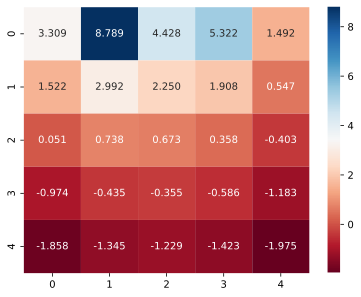

In [4]:
grid = GridWorld(5, 5, [(1, 21, 10), (3, 13, 5)])
values = grid.bellman_solution()
sns.heatmap(values, cmap='RdBu', annot=True, fmt=".3f");

## Action-value function

Value (**expected return**) of following policy $\pi$ after committing action $a$ state $s$:

$$
    q_\pi(s, a) = \mathbb E_\pi[G_t \vert S_t = s, A_t = a]
$$

````{admonition} Question
:class: important
How to write $v_\pi(s)$ in terms of $q_\pi(s, a)$?

```{admonition} Answer
:class: tip, dropdown

$$
v_\pi(s) = \sum\limits_a \pi(a\vert s) q_\pi(s, a)
$$

```
````


**Bellman expectation equality** for $q_\pi(s, a)$


MDP-1:

$$
    q_\pi(s,a) = \sum\limits_{r, s'}p(r, s'\vert s, a)(r + \gamma v_{\pi}(s'))
$$


Since $v_\pi(s) = \sum\limits_{a} \pi(a\vert s) q_\pi(s, a)$, we obtain

$$
    q_\pi(s,a) = \sum\limits_{r, s'}p(r, s'\vert s, a)\Big(r + \gamma \sum\limits_{a'}\pi(a'\vert s') q_\pi(s', a')\Big)
$$

MDP-2:

$$
    q_\pi(s,a) =  \mathcal R(s, a) + \gamma\sum\limits_{s'}p(s'\vert s, a)\sum\limits_{a'}\pi(a'\vert s') q_\pi(s', a')
$$

Once again the equation stands for some fixed policy $\pi$

## Optimal policy

Optimal policy $\pi_*$ is the one with the largest $v_\pi(s)$:

$$
    v_*(s) = \max\limits_\pi v_\pi(s), \quad v_*(s) = v_{\pi_*}(s)
$$
$$
    q_*(s, a) = \max\limits_\pi q_\pi(s, a), \quad q_*(s, a) = q_{\pi_*}(s, a)
$$

Note that both $v_*(s)$ and $q_*(s, a)$ do not depend on $\pi$ anymore

If we now optimal action-value function $q_*(s, a)$, then the optimal deterministic policy can be found as

$$
    \pi_*(a\vert s) = \begin{cases}
    1, & a = \arg\max\limits_a q_*(s, a), \\
    0, & \text{otherwise}.
    \end{cases}
$$

**Bellman optimality equality** for $v_*(s)$

MDP-1:

$$
v_*(s) = \max\limits_a q_*(s, a) = \max\limits_a\sum\limits_{r, s'}p(r, s'\vert s, a)(r + \gamma v_*(s'))
$$

MDP-2:

$$
v_*(s) = \max\limits_a \Big\{\mathcal R(s, a) + \gamma\sum\limits_{s'}p(s'\vert s, a)v_*(s')\Big\}
$$

```{admonition} Exercise
:class: important
Compute $v_*$ of the best state $A$.
```

In [5]:
10 / (1- 0.9**5)

24.419428096993972

## Value iteraion

1. Initialize $v_i(s)=0$, for all $s \in \mathcal S$

2. While $\|v_{i+1} - v_i\| > \varepsilon$:
 
3. $\quad v_{i+1}(s) = \max\limits_a \sum\limits_{r, s'} p(r, s' | s,a)\big(r + \gamma v_{i}(s')\big)$, $s \in \mathcal S$

After $n$ iterations $v_n(s) \approx v_*(s)$ for all $s\in\mathcal S$, so the optimal policy is now evaluated as

$$
    \pi_*(s) = \arg\max\limits_a \sum\limits_{r, s'} p(r, s' | s,a)\big(r + \gamma v_*(s')\big)
$$

**Q.** How to update the value function in MDP-2?

$\quad v_{i+1}(s) = \max\limits_a \big\{\mathcal R(s, a) +\gamma\sum\limits_{s'} p(s' | s,a) v_{i}(s')\big\}$

Apply the value iteration methods to the gridworld environment:

In [6]:
grid = GridWorld(5, 5, [(1, 21, 10), (3, 13, 5)])
for i in range(1000):
    diff = grid.update_state_values()
    print(f"diff at iteration {i}: {diff:.6f}")
    if diff < 1e-3:
        break

diff at iteration 0: 11.180340
diff at iteration 1: 16.837458
diff at iteration 2: 15.153712
diff at iteration 3: 14.390083
diff at iteration 4: 13.201365
diff at iteration 5: 11.359212
diff at iteration 6: 10.087099
diff at iteration 7: 8.899113
diff at iteration 8: 8.128209
diff at iteration 9: 7.426842
diff at iteration 10: 6.520376
diff at iteration 11: 5.832493
diff at iteration 12: 5.165771
diff at iteration 13: 4.786819
diff at iteration 14: 4.422070
diff at iteration 15: 3.967694
diff at iteration 16: 3.580832
diff at iteration 17: 3.102996
diff at iteration 18: 2.886449
diff at iteration 19: 2.703556
diff at iteration 20: 2.447296
diff at iteration 21: 2.182663
diff at iteration 22: 1.821722
diff at iteration 23: 1.697455
diff at iteration 24: 1.627680
diff at iteration 25: 1.530449
diff at iteration 26: 1.368849
diff at iteration 27: 1.087588
diff at iteration 28: 1.036305
diff at iteration 29: 1.036065
diff at iteration 30: 1.016825
diff at iteration 31: 0.915050
diff at ite

#### Policy Iteration (another way to compute optimal policies)

Write $\pi(S_i)$ as action selected in the $i$’th state. Then $\pi$ is a policy.

Write $\pi^t = t$’th policy on t’th iteration


Algorithm:
$\pi^{\circ}$ is any randomly chosen policy

compute $J^{\circ}(S_i)$ as long term reward starting at $S_i$ using $\pi^{\circ}$

$\pi_1(S_i) = \arg \max\limits_a [r_i + \gamma \sum_j P^a_{ij} J^{\circ}(S_j)]$

$J_1 = \dots$

$\pi_2(S_i) = \dots$

Keep computing $\pi^1 \pi^2 \pi^3 \dots$ until $\pi^k = \pi^{k+1}$. Then one will have an optimal policy.

## Markov Chain

Markov chains is a model that depicts a sequence of possible events where probabilities for the next state are based solely on its previous event state, not the states before.

In simple words, the probability that $n+1$ steps will be $x$ depends only on the nth steps not the complete sequence of steps that came before $n$.

This property is known as Memorylessness.

| -      | A | E |
| ----------- | ----------- | ----------- |
| A      | 0.6       | 0.4       |
| E   | 0.7        | 0.3        |

So it is possible to represent Markov Chain with the help of an adjacency matrix.

- If the Markov chain has N possible states, the matrix will be an NxN matrix.
- Each row of this matrix should sum to 1.
- a Markov chain also has an Initial State Vector of order Nx1.

In [7]:
# Encoding this states to numbers as it
# is easier to deal with numbers instead 
# of words.
state = ["A", "E"]
 
# Assigning the transition matrix to a variable
# i.e a numpy 2d matrix.
MyMatrix = np.array([[0.6, 0.4], [0.7, 0.3]])
 
# Simulating a random walk on our Markov chain 
# with 20 steps. Random walk simply means that
# we start with an arbitrary state and then we
# move along our markov chain.
n = 20
 
# decide which state to start with
StartingState = 0
CurrentState = StartingState
 
# printing the stating state using state
# dictionary
print(state[CurrentState], "--->", end=" ")
 
while n-1:
    # Deciding the next state using a random.choice()
    # function,that takes list of states and the probability
    # to go to the next states from our current state
    CurrentState = np.random.choice([0, 1], p=MyMatrix[CurrentState])
     
    # printing the path of random walk
    print(state[CurrentState], "--->", end=" ")
    n -= 1
print("stop")
 
# Let us find the stationary distribution of our 
# Markov chain by Finding Left Eigen Vectors
# We only need the left eigen vectors
MyValues, left = scipy.linalg.eig(MyMatrix, right=False, left=True)
 
print("left eigen vectors = \n", left, "\n")
print("eigen values = \n", MyValues)
 
# Pi is a probability distribution so the sum of 
# the probabilities should be 1 To get that from 
# the above negative values we just have to normalize
pi = left[:, 0]
pi_normalized = [(x/np.sum(pi)).real for x in pi]
pi_normalized

A ---> E ---> A ---> A ---> E ---> A ---> A ---> E ---> A ---> A ---> E ---> E ---> A ---> E ---> A ---> A ---> A ---> A ---> A ---> A ---> stop
left eigen vectors = 
 [[ 0.86824314 -0.70710678]
 [ 0.49613894  0.70710678]] 

eigen values = 
 [ 1. +0.j -0.1+0.j]


[0.6363636363636365, 0.36363636363636365]

In [8]:
display_quiz(questions[2])

<IPython.core.display.Javascript object>

### Markov chains in NLP

Markov chain is a mathematical model that is utilized to simulate random processes occurring over a duration of time. It consists of a set of states and the transitions between them. These transitions are probabilistic.

- **Transition matrix**: This is a square matrix that describes the probability of moving from one state to another. If there are n states in the Markov chain, the transition matrix will be an n x n matrix, where each element (i,j) of the matrix represents the probability of moving from state i to state j. The sum of each row of the transition matrix must be 1, as the probabilities of moving to each state from the current state must add up to 1.
- **Chapman-Kolmogorov equation**: These equations state that the probability of moving from one state to another over a sequence of steps is the product of the transition probabilities for each step. This means that we can compute the probability of a particular sequence of transitions by multiplying together the probabilities of each individual transition.

#### Markov Chains in Natural Language Processing (NLP)
They have been widely used in Natural Language Processing (NLP) applications, such as text generation, speech recognition, and sentiment analysis.

#### Markov chain algorithm for generating sentences

We start by analyzing a corpus of text to determine the probabilities of transitioning from one word to another.

> The quick brown fox jumps over the lazy dog.

We can create a Markov chain by treating each word as a state and analyzing the probability of transitioning from one word to another. For example, we might find that the probability of transitioning from “the” to “quick” is 0.5, the probability of transitioning from “quick” to “brown” is 1.0, and so on based on large corpus text data study. Once we have computed the transition probabilities, we can generate a new sentence by starting with an initial word and randomly selecting the next word based on the transition probabilities.

In [9]:
import re
 
text = "I love cats. Cats are my favorite animal. I have two cats."
 
# Remove unnecessary characters
text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
 
# Convert to lowercase
text = text.lower()
 
text

'i love cats cats are my favorite animal i have two cats'

Next, we generate N-grams from the preprocessed text. N-grams are contiguous sequences of n words, where n is usually 2 or 3. For example, “the cat sat” is a 3-gram.

In [10]:
from nltk import ngrams
 
n = 2
 
# Generate 2-grams
n_grams = ngrams(text.split(), n)
 
# Convert to list of tuples
n_grams = list(n_grams)
 
n_grams

[('i', 'love'),
 ('love', 'cats'),
 ('cats', 'cats'),
 ('cats', 'are'),
 ('are', 'my'),
 ('my', 'favorite'),
 ('favorite', 'animal'),
 ('animal', 'i'),
 ('i', 'have'),
 ('have', 'two'),
 ('two', 'cats')]

After generating N-grams, we build a transition matrix that represents the probabilities of moving from one word to another. We calculate these probabilities by counting the number of times a particular word appears after another word in the N-grams.

In [11]:
# Get unique words
unique_words = list(set(text.split()))

# Create transition matrix
transition_matrix = np.zeros((len(unique_words), len(unique_words)))

# Fill transition matrix
for i, word in enumerate(unique_words):
	for j, next_word in enumerate(unique_words):
		# Count the number of times a word appears followed by next_word
		count = 0
		for n_gram in n_grams:
			if n_gram[0] == word and n_gram[1] == next_word:
				count += 1
		transition_matrix[i, j] = count

# Normalize transition matrix
transition_matrix = transition_matrix / \
	transition_matrix.sum(axis=1, keepdims=True)



In [12]:
transition_matrix = np.array(transition_matrix)

heatmap = go.Figure(data=go.Heatmap(
    z=transition_matrix,
    colorscale='Viridis',
    x=[f'State {i+1}' for i in range(len(transition_matrix))],
    y=[f'State {i+1}' for i in range(len(transition_matrix))]
))

heatmap.update_layout(
    title='Transition Matrix from state to state',
    xaxis=dict(title='To State'),
    yaxis=dict(title='From State'),
    height=600,
    width=600,
)

# Show the plot
heatmap.show()

Once we have the transition matrix, we can generate new text by starting with an initial word and randomly selecting the next word based on the probabilities in the transition matrix. We repeat this process until we have generated the desired amount of text.

In [13]:
# Set initial word
current_word = "i"

# Generate text
generated_text = current_word

for i in range(10):
	# Get index of current word
	current_word_index = unique_words.index(current_word)

	# Get probabilities for next word
	probabilities = transition_matrix[current_word_index]

	# Select next word randomly based on probabilities
	next_word_index = np.random.choice(len(unique_words), p=probabilities)
	next_word = unique_words[next_word_index]

	# Add next word to generated text
	generated_text += " " + next_word

	# Set current word to next word
	current_word = next_word

# Print generated text
generated_text


'i love cats are my favorite animal i have two cats'

In [14]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Assuming you have the necessary variables and functions defined

# Set initial word

# Generate text function
def generate_text(parameter):
    global current_word
    generated_text = current_word

    for _ in range(int(parameter)):
        current_word_index = unique_words.index(current_word)
        probabilities = transition_matrix[current_word_index]
        next_word_index = np.random.choice(len(unique_words), p=probabilities)
        next_word = unique_words[next_word_index]
        generated_text += " " + next_word
        current_word = next_word

    return generated_text

# Function to update and display generated text
def update_text(parameter):
    generated_text = generate_text(parameter)
    print("Generated Text:", generated_text)

# Create a slider
slider = widgets.FloatSlider(value=0, min=0, max=30, step=1, description='Word count')

# Create an interactive display
interactive_plot = widgets.interactive(update_text, parameter=slider)

# Display the slider and the initial generated text
display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, description='Word count', max=30.0, step=1.0), Output()), _dom_cl…

#### Build larger Markov model

In [15]:
dataset = load_dataset("cfilt/iitb-english-hindi")
dataset

c:\Users\kaysar\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\repocard.py:105: UserWarning:

Repo card metadata block was not found. Setting CardData to empty.



DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
})

Create an English text corpus

In [16]:
English = []

for translation_pair in dataset["train"]["translation"]:
	english = translation_pair['en']
	English.append(english.strip("\n"))

English = English[::16] # just for performance


Preprocessing

In [17]:
def Tokenize(txt):
	cleaned_txt = []
	for line in txt:
		line = line.lower()
		line = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-\\]", "", line)
		tokens = word_tokenize(line)
		words = [word for word in tokens if word.isalpha()]
		cleaned_txt += words
	return cleaned_txt


Tokens = Tokenize(English)
print("number of words = ", len(Tokens))


number of words =  1310990


Build the Markov Model

In [18]:
class MarkovModel:

	def __init__(self, n_gram=2):
		self.n_gram = n_gram
		self.markov_model = {}

	def build_model(self, text):
		for i in range(len(text)-self.n_gram-1):
			curr_state, next_state = "", ""
			for j in range(self.n_gram):
				curr_state += text[i+j] + " "
				next_state += text[i+j+self.n_gram] + " "
			curr_state = curr_state[:-1]
			next_state = next_state[:-1]
			if curr_state not in self.markov_model:
				self.markov_model[curr_state] = {}
				self.markov_model[curr_state][next_state] = 1
			else:
				if next_state in self.markov_model[curr_state]:
					self.markov_model[curr_state][next_state] += 1
				else:
					self.markov_model[curr_state][next_state] = 1

		# calculating transition probabilities
		for curr_state, transition in self.markov_model.items():
			total = sum(transition.values())
			for state, count in transition.items():
				self.markov_model[curr_state][state] = count/total

	def get_model(self):
		return self.markov_model


Trained model

In [19]:
markov = MarkovModel()
markov.build_model(Tokens)
print("number of states = ", len(markov.get_model().keys()))


number of states =  499952


Generate the new text

In [20]:
def generate_entences(markov, limit=100, start='i am'):
	n = 0
	curr_state = start
	next_state = None
	story = ""
	story += curr_state+" "
	while n < limit:
		next_state = random.choices(
			list(markov[curr_state].keys()),
			list(markov[curr_state].values()))

		curr_state = next_state[0]
		story += curr_state+" "
		n += 1
	return story


# Generate 10 senetences
for i in range(10):
	print(str(i)+". ", generate_entences(
		markov.get_model(), start='you are', limit=7))


0.  you are in a knowledge based on observation reasoning and found them prostrate in their dwellings 
1.  you are employed or permitted to work in progress and prosperity of the people more gandhiji 
2.  you are one of the full moon in the silver jubilee celebrations of m weighing tons 
3.  you are doing those their refuge is gehenna hell that day is celebrated to commemorate the 
4.  you are truthful the lord of the heavens and the amount of the capital asset as 
5.  you are reminded but you are an ignorant people when his anger had subsided moses took 
6.  you are childless and your heirs are your other relationships are also found lemon geographic information 
7.  you are not a little embarrassment the more important functions discharged by it are stolen in 
8.  you are you afraid of them aforetime they used to reduce the scales of money it 
9.  you are required to be laid now let us acquaint ourselves with some of the wealth 
